In [34]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

from sklearn.metrics import mean_squared_error

In [102]:
#Read NN and BMS data
n=2;id=0;function='tanh' #tanh, leaky_ReLU
NPAR=10 #10, 20

#Read NN data
train_size=60
file_model='NN_model_' + function + '_train_' +str(train_size)+ '_NREP_10_data' + '.csv'
model_d='../data/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)

#Read BMS data
filename='BMS_' + function + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '_id_' + str(id) + '.csv'
print(filename)
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
display(trace)

BMS_tanh_trace.2_prior_10_id_0.csv


,t,H,expr,parvals,kk1,kk2,kk3
0,0,-4.662822,_a6_,"{'d0': {'_a6_': 0.391881119187489, '_a0_': 1.0...",{'d0': 2.623638110760738},-9.325644,0.000000
1,1,-4.662822,_a6_,"{'d0': {'_a6_': 0.391881119187489, '_a0_': 1.0...",{'d0': 2.623638110760738},-9.325644,0.000000
2,2,-4.662822,_a6_,"{'d0': {'_a6_': 0.391881119187489, '_a0_': 1.0...",{'d0': 2.623638110760738},-9.325644,0.000000
3,3,-4.662822,_a6_,"{'d0': {'_a6_': 0.391881119187489, '_a0_': 1.0...",{'d0': 2.623638110760738},-9.325644,0.000000
4,4,-4.662822,_a6_,"{'d0': {'_a6_': 0.391881119187489, '_a0_': 1.0...",{'d0': 2.623638110760738},-9.325644,0.000000
...,...,...,...,...,...,...,...
49995,49995,-151.152652,pow2((((exp(((exp(((_a1_ + (_a7_ + ((((_a1_ / ...,"{'d0': {'_a0_': -3025903.642265896, '_a1_': 0....",{'d0': 7.952171591321898e-05},-604.907774,151.301234
49996,49996,-151.152652,pow2((((exp(((exp(((_a1_ + (_a7_ + ((((_a1_ / ...,"{'d0': {'_a0_': -3025903.642265896, '_a1_': 0....",{'d0': 7.952171591321898e-05},-604.907774,151.301234
49997,49997,-151.152652,pow2((((exp(((exp(((_a1_ + (_a7_ + ((((_a1_ / ...,"{'d0': {'_a0_': -3025903.642265896, '_a1_': 0....",{'d0': 7.952171591321898e-05},-604.907774,151.301234
49998,49998,-151.152652,pow2((((exp(((exp(((_a1_ + (_a7_ + ((((_a1_ / ...,"{'d0': {'_a0_': -3025903.642265896, '_a1_': 0....",{'d0': 7.952171591321898e-05},-604.907774,151.301234


In [103]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()
y = dn.y

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [104]:
#mdl model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

In [105]:
#Sample trace
sample_step=25
trace_s=trace.iloc[::sample_step, :]
models=len(trace_s.index)
print(models)

2000


In [106]:
dall = deepcopy(dn)

dsample= pd.DataFrame({'ybms_' + str(row): [] for row in range(models)})
expressions=[]
for row in range(models):
    H_r, expr_r, parvals_r = trace_s.iloc[row].H, trace_s.iloc[row].expr, ast.literal_eval(trace_s.iloc[row].parvals)
    
    t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=expr_r,
)
    t.set_par_values(deepcopy(parvals_r))

    dsample['ybms_' + str(row)] = t.predict(x)
    expressions.append(t.latex() )

#Remove columns with nans and infs
dsample.replace([np.inf, -np.inf], np.nan, inplace=True)
dsample=dsample.dropna(axis='columns')

#Calculate median of sampled models
dmedian=pd.DataFrame({'ybms_median': dsample[ [i for i in dsample.columns] ].median(axis=1)})
#Add median column to dataframe
dsample=pd.concat([dsample,dmedian], axis=1)

In [107]:
#Find the model with the minimum MSE
mse_models=[mean_squared_error(dsample[i], dsample.ybms_median) for i in dsample.columns[:-1]]

#The best model minimezes the error with the median prediction
best_model=mse_models.index(min(mse_models)) #find best model

print(min(mse_models))
print(best_model)

3.605139331552952e-07
965


,x1,y,rep,ymodel,ybms_965
0,-1.95,0.688229,2.0,0.688443,0.684178
1,-1.90,0.675937,2.0,0.675810,0.675840
2,-1.85,0.663654,2.0,0.663349,0.665698
3,-1.80,0.651427,2.0,0.651072,0.654235
4,-1.75,0.639311,2.0,0.638994,0.641907
...,...,...,...,...,...
75,1.80,0.416738,2.0,0.299993,0.284020
76,1.85,0.429237,2.0,0.300073,0.284020
77,1.90,0.441836,2.0,0.300138,0.284020
78,1.95,0.454457,2.0,0.300191,0.284020


      x1         y  rep    ymodel  ybms_965  ybms_median
0  -1.95  0.688229  2.0  0.688443  0.684178     0.684916
1  -1.90  0.675937  2.0  0.675810  0.675840     0.675778
2  -1.85  0.663654  2.0  0.663349  0.665698     0.664459
3  -1.80  0.651427  2.0  0.651072  0.654235     0.652018
4  -1.75  0.639311  2.0  0.638994  0.641907     0.639578
..   ...       ...  ...       ...       ...          ...
75  1.80  0.416738  2.0  0.299993  0.284020     0.283743
76  1.85  0.429237  2.0  0.300073  0.284020     0.283743
77  1.90  0.441836  2.0  0.300138  0.284020     0.283743
78  1.95  0.454457  2.0  0.300191  0.284020     0.283743
79  2.00  0.467024  2.0  0.300234  0.284020     0.283743

[80 rows x 6 columns]
mdl model contains nans
mdl model contains nans


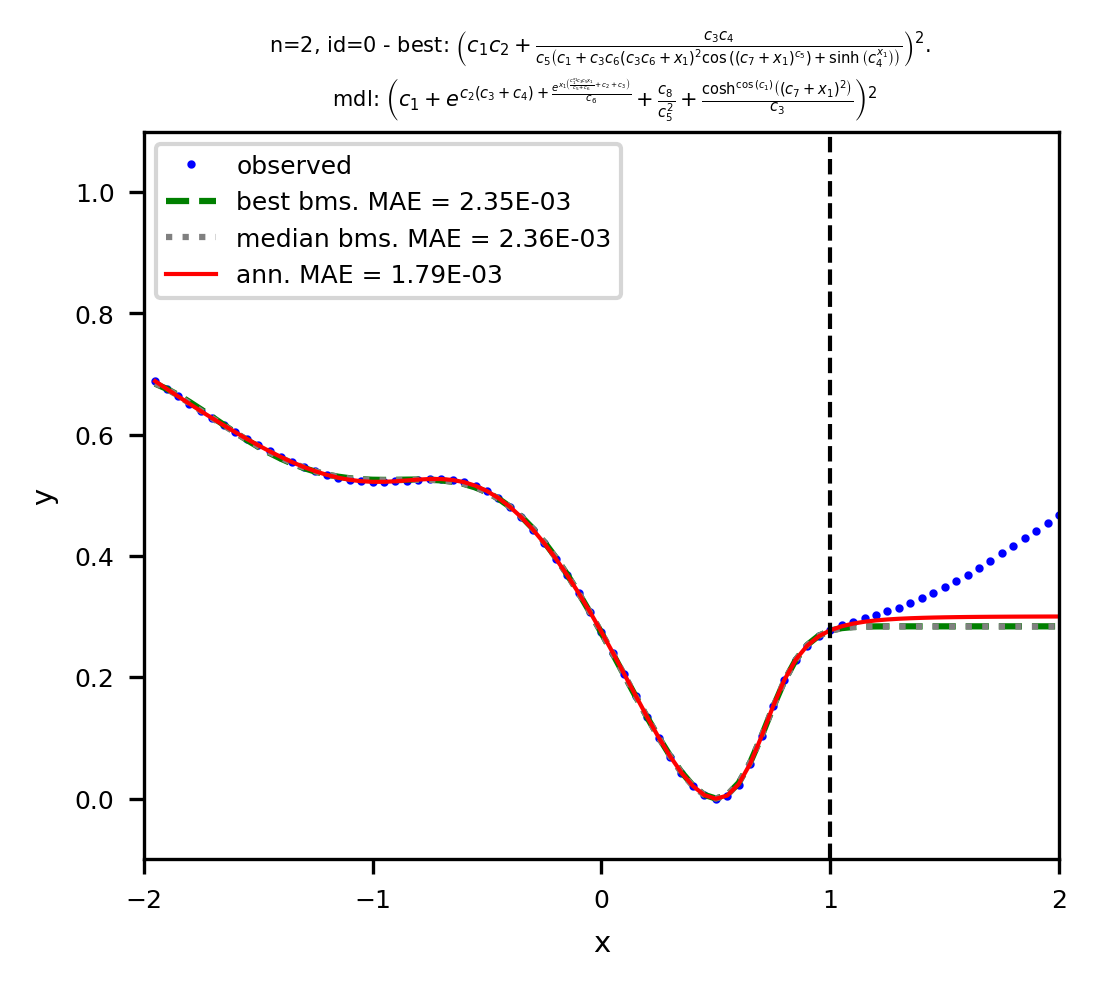

In [108]:
dn['ybms_'+ str(best_model)]=dsample['ybms_'+ str(best_model)]
display(dn)
dn['ybms_median']=dsample['ybms_median']
dn['ybms_mdl'] = t.predict(x)

#dsample.replace([np.inf, -np.inf], np.nan, inplace=True)
dn=dn.dropna(axis='columns')

#print(dn['ybms_mdl'])

#dn['ybms_mdl']=dn['ybms_mdl'].dropna()
print(dn)

MAE_bms=mean_squared_error(dn['ybms_' + str(best_model)],dn.y)

MAE_median=mean_squared_error(dn['ybms_median'],dn.y)
MAE_nn=mean_squared_error(dn.ymodel,dn.y)

try:
    MAE_mdl=mean_squared_error(dn.ybms_mdl,dn.y)
except AttributeError:
    print("mdl model contains nans")


#Plot
train_border=dn.loc[train_size-1]['x1']
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm

Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          

fig=figure(figsize=(width,height), dpi=300)


plt.title('n=%d, id=%d - best: $%s$. \n mdl: $%s$' % (n, id, expressions[best_model], t.latex()),fontsize=size_title)
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed')  
try:
    plt.plot(dn['x1'], dn['ybms_mdl'],color='olive', linestyle=':', label='mdl. MAE = %.2E' % MAE_mdl)
except KeyError:
    print("mdl model contains nans")
plt.plot(dn.x1, dn['ybms_'+ str(best_model)], color='green', linestyle='--',label='best bms. MAE = %.2E' % MAE_bms)
plt.plot(dn.x1, dn.ybms_median, color='gray', linestyle=':',label='median bms. MAE = %.2E' % MAE_median)
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann. MAE = %.2E' % MAE_nn) 

plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')


plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.1,1.1)                                               

Name_figure='best_median_mdl_' + function + '_' + str(n) + '_' + str(id)
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

In [ ]:
fig=figure(figsize=(width,height), dpi=300)

plt.plot([0,1], [0,1],linestyle='--',linewidth=line_w)
plt.scatter(dn.loc[:train_size-1]['y'],dn.loc[:train_size-1]['ybms_'+ str(best_model)] , s=marker_s-1, color='red',label='train')
plt.scatter(dn.loc[train_size:]['y'],dn.loc[train_size:]['ybms_'+ str(best_model)] , s=marker_s-1, color='orange',label='test')

plt.show()